In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/archive_3


In [ ]:
!unzip /content/archive_3.zip -d /content/archive_3


In [ ]:
!ls /content/archive_3


Dataset


In [ ]:
DATA_DIR = "/content/archive_3/Dataset"

dataset = ImageFolder(DATA_DIR)
print("Số ảnh:", len(dataset))
print("Class mapping:", dataset.class_to_idx)

Số ảnh: 9097
Class mapping: {'25-30': 0, '42-48': 1, '6-20': 2, '60-98': 3}


In [ ]:
CHILD_LABEL = dataset.class_to_idx['6-20']


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])


In [ ]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])


In [ ]:
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform


In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)


In [ ]:
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)

# Freeze toàn bộ backbone
for param in model.parameters():
    param.requires_grad = False

# Thay classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 4)
)

model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct = 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


In [ ]:
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.0.weight
fc.0.bias
fc.3.weight
fc.3.bias


In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    print(
        f"Fine-tune Epoch {epoch+1}/{EPOCHS} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )


Fine-tune Epoch 1/5 | Train Acc: 0.6768 | Val Acc: 0.7269
Fine-tune Epoch 2/5 | Train Acc: 0.8116 | Val Acc: 0.7555
Fine-tune Epoch 3/5 | Train Acc: 0.8817 | Val Acc: 0.7604
Fine-tune Epoch 4/5 | Train Acc: 0.9314 | Val Acc: 0.7319
Fine-tune Epoch 5/5 | Train Acc: 0.9512 | Val Acc: 0.7604


In [ ]:
torch.save(model.state_dict(), "age_group_model_final.pth")


In [ ]:
from google.colab import files
files.download("age_group_model_final.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())


<Figure size 600x600 with 0 Axes>

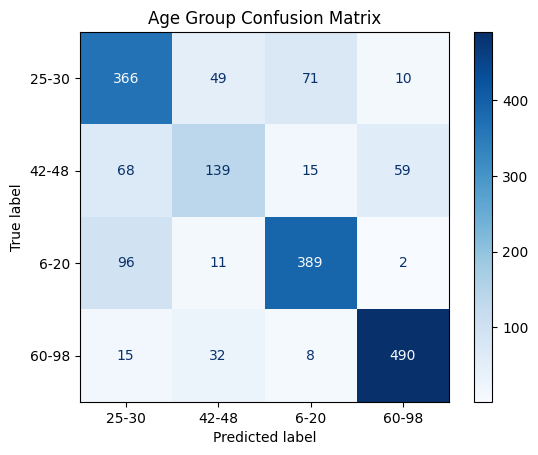

In [ ]:
class_names = list(dataset.class_to_idx.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues")
plt.title("Age Group Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_true_child = []
y_pred_child = []

for t, p in zip(y_true, y_pred):
    y_true_child.append(1 if t == CHILD_LABEL else 0)
    y_pred_child.append(1 if p == CHILD_LABEL else 0)


In [ ]:
print("Child Detection Accuracy:",
      accuracy_score(y_true_child, y_pred_child))

print(classification_report(
    y_true_child,
    y_pred_child,
    target_names=["Adult", "Child"]
))


Child Detection Accuracy: 0.8884615384615384
              precision    recall  f1-score   support

       Adult       0.92      0.93      0.92      1322
       Child       0.81      0.78      0.79       498

    accuracy                           0.89      1820
   macro avg       0.86      0.86      0.86      1820
weighted avg       0.89      0.89      0.89      1820



In [ ]:
img_path = "/content/hinh-anh-tre-em-voi-nu-cuoi-toa-sang.jpg"


In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# ===== LOAD MODEL =====
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 4)
)
model.load_state_dict(torch.load("age_group_model_final.pth", map_location=device))
model = model.to(device)
model.eval()

# ===== TRANSFORM =====
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

# ===== LOAD IMAGE =====
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# ===== INFERENCE =====
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    pred_label = probs.argmax(1).item()

# ===== MAPPING =====
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
age_group = idx_to_class[pred_label]
is_child = (pred_label == CHILD_LABEL)

print("Predicted age group:", age_group)
print("Child detected:", is_child)
print("Confidence:", probs[0][pred_label].item())


Predicted age group: 6-20
Child detected: True
Confidence: 0.9999992847442627
